In [65]:
import sys
sys.path.append('/home/jupyter/TimestampActionSeg/')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import copy
import numpy as np
import torch
from model import Trainer, MultiStageModel
from batch_gen import BatchGenerator
from random_walk import run_random_walk
import argparse
import random
import time
import os
from eval import evaluate
import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools


In [195]:
# helper functions
import sys
from eval import f_score, edit_score

class MetricLoger():
    def __init__(self, overlap = [.1, .25, .5], ignore_ind = -100):
        self.ignore_ind = ignore_ind
        self.overlap = overlap
        self.tp, self.fp, self.fn = np.zeros(3), np.zeros(3), np.zeros(3)

        self.correct = 0
        self.total = 0
        self.edit = 0
        self.num_vids = 0

    def update(self, labels, preds):
        if self.ignore_ind:
            lim = np.where(labels == self.ignore_ind)[0]
            if len(lim):
                lim = min(lim)
            else:
                lim = len(labels)

            labels = labels[:lim]
            preds = preds[:lim]

        self.num_vids += 1
        for i in range(len(labels)):
            self.total += 1
            if labels[i] == preds[i]:
                self.correct += 1

        self.edit += edit_score(preds, labels)

        for s in range(len(self.overlap)):
            tp1, fp1, fn1 = f_score(preds, labels, self.overlap[s])
            self.tp[s] += tp1
            self.fp[s] += fp1
            self.fn[s] += fn1

    def calc(self):
        mets = {}
        for s in range(len(self.overlap)):
            precision = self.tp[s] / float(self.tp[s] + self.fp[s])
            recall = self.tp[s] / float(self.tp[s] + self.fn[s])

            f1 = 2.0 * (precision * recall) / (precision + recall)
            f1 = np.nan_to_num(f1) * 100
            mets['F1@{:.2f}'.format(self.overlap[s])] = f1
            # print('F1@%0.2f: %.4f' % (self.overlap[s], f1))
        edit = (1.0 * self.edit) / self.num_vids
        mets['Edit'] = edit
        acc = 100 * float(self.correct) / self.total
        mets['Acc'] = acc
        # print('Edit: %.4f' % edit)
        # print("Acc: %.4f" % acc)
        return mets

def run_epoch(batch_gen, model, epoch, use_rw, is_train):
    epoch_loss = 0
    pseudo_correct = 0
    labels_correct = 0
    pseudo_to_labels_correct = 0
    timestamps_correct = 0
    num_timestamps = 0
    total = 0
    while batch_gen.has_next():
        batch_input, batch_label, mask, batch_confidence = batch_gen.next_batch(batch_size)
        batch_input, batch_label, mask = batch_input.to(device), batch_label.to(device), mask.to(device)
        if is_train:
            optimizer.zero_grad()
            middle_pred, predictions = model(batch_input, mask)
        else:
            with torch.no_grad():
                middle_pred, predictions = model(batch_input, mask)
        
        if epoch < start_epochs:
            # 
            batch_pseudo = batch_gen.get_single_random(batch_size, batch_input.size(-1))
        else:
            if use_rw == 'feature':
                batch_pseudo = batch_gen.get_rw_preds(batch_size, middle_pred.detach().cpu())
            elif use_rw == 'image':
                batch_pseudo = batch_gen.get_image_based_rw_preds(batch_size, middle_pred.detach().cpu())
            elif use_rw == 'no':
                batch_pseudo = batch_gen.get_boundary(batch_size, middle_pred.detach().cpu())
            else:
                raise 
        batch_pseudo = batch_pseudo.to(device)

        loss = 0
        for p in predictions:
            loss += ce(p.transpose(2, 1).contiguous().view(-1, num_classes), batch_pseudo.view(-1))
            loss += 0.15 * torch.mean(torch.clamp(
                mse(F.log_softmax(p[:, :, 1:], dim=1), F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                max=16) * mask[:, :, 1:])
            loss += 0.075 * confidence_loss(p, batch_confidence, device)

        epoch_loss += loss.item()
        epoch_loss += loss.item()
        if is_train:
            loss.backward()
            optimizer.step()

        _, predicted = torch.max(predictions[-1].data, 1)

        for i, vid_name in enumerate(batch_gen.list_of_examples[batch_gen.index - batch_size:batch_gen.index]):
            timestamp_inds = torch.tensor(batch_gen.random_index[vid_name])
            num_timestamps += len(timestamp_inds)
            timestamps_correct += (batch_label[i, timestamp_inds] == predicted[i, timestamp_inds]).float().sum().item()
        
        pseudo_to_labels_correct += ((batch_label == batch_pseudo).float()*mask[:, 0, :].squeeze(1)).sum().item()
        pseudo_correct += ((predicted == batch_pseudo).float()*mask[:, 0, :].squeeze(1)).sum().item()
        labels_correct += ((predicted == batch_label).float()*mask[:, 0, :].squeeze(1)).sum().item()
        total += torch.sum(mask[:, 0, :]).item()

    batch_gen.reset()
    mets = {'loss': epoch_loss / len(batch_gen.list_of_examples),
            'timestamps_acc' : float(timestamps_correct) / num_timestamps,
            'pseudo_acc' : float(pseudo_correct) / total,
            'labels_acc' : float(labels_correct) / total,
            'pseudo_to_labels': float(pseudo_to_labels_correct) / total,
            'epoch': epoch + 1}
    return mets


def run_eval(model, batch_gen, actions_dict):
    actions_dict_rev = {v:k for k,v in actions_dict.items()}
    met = MetricLoger()
    model.eval()
    batch_gen.reset()
    with torch.no_grad():
        while batch_gen.has_next():
            batch_input, batch_target, mask, batch_confidence = batch_gen.next_batch(batch_size)
            batch_input, batch_target, mask = batch_input.to(device), batch_target.to(device), mask.to(device)
            middle_pred, predictions = model(batch_input, mask)
            _, predicted = torch.max(predictions[-1].data, 1)
    target = batch_target.detach().cpu().numpy()
    predicted = predicted.detach().cpu().numpy()
    for t, p in zip(target, predicted):
        lim = np.where(t == -100)[0]
        if len(lim):
            lim = min(lim)
        else:
            lim = len(t)
        met.update([actions_dict_rev[i] for i in t[:lim]],
                   [actions_dict_rev[i] for i in p[:lim]])
    mets_dict = met.calc()
    return mets_dict


def extract_prior(preds, temp=1., norm_axis=0, method='thresh', k=1, thresh=0.9, value=1., smooth=None):
  """preds.shape [num_frames, num_classes]
  norm_axis = 0 -> per frame
  norm_axis = 1 -> per phase
  """
  duration = preds.shape[0]
  softmax_preds = scipy.special.softmax(preds * temp, norm_axis)
  sparse_prior = np.zeros_like(softmax_preds)
  phase2timestamps = {}
  for i, phase_pred in enumerate(softmax_preds.T):
    if method == 'thresh':
      timestamps = np.where(phase_pred > phase_pred.max() * thresh)[0]
    elif method == 'topk':
      timestamps = np.argsort(phase_pred)[::-1][:k]
    elif method == 'thresh_and_topk':
      timestamps = np.argsort(phase_pred)[::-1][:k]
      timestamps = [t for t in timestamps if phase_pred[t] > phase_pred.max() * thresh]
    else:
      raise ValueError
    if len(timestamps):
      phase2timestamps[i] = timestamps
      for j in timestamps:
        sparse_prior[j, i] = value
        if smooth:
          for m, n in enumerate(range(j - smooth, j)):
            if n >= 0:
              sparse_prior[n, i] = (value / (smooth + 1) * (m + 1))
          for m, n in enumerate(range(j + smooth, j, -1)):
            if n < duration:
              sparse_prior[n, i] = (value / (smooth + 1) * (m + 1))
  return sparse_prior, phase2timestamps

params = {'seed': 0,
          'topk': 1,
          'n_neighbors': 50,
          'average_method': 'min',
          'affine_power_a': 6,
          'prior_lambda': 5e-3,
          # 'num_labels': num_labels,
          'smooth': 10}


def run_eval_with_rw(model, batch_gen, actions_dict, batch_size, features_path, dataset, extract_prior_params, params):
    actions_dict_rev = {v:k for k,v in actions_dict.items()}
    timestamps_acc = []
    num_timestamps = []
    met = MetricLoger()
    model.eval()
    batch_gen.reset()
    with torch.no_grad():
        while batch_gen.has_next():
            batch = batch_gen.list_of_examples[batch_gen.index:batch_gen.index + batch_size]
            batch_input, batch_target, mask, batch_confidence = batch_gen.next_batch(batch_size)
            batch_input, batch_target, mask = batch_input.to(device), batch_target.to(device), mask.to(device)
            middle_pred, predictions = model(batch_input, mask)
            predicted = predictions[-1].data
            batch_input = batch_input.detach().cpu().numpy()
            target = batch_target.detach().cpu().numpy()
            predicted = predicted.detach().cpu().numpy()

            for vid, t, p in zip(batch, target, predicted):
                lim = np.where(t == -100)[0]
                if len(lim):
                    lim = min(lim)
                else:
                    lim = len(t)
                t = t[:lim]
                p = p[:, :lim]
                f = np.load(features_path + vid.split('.')[0] + '.npy')
                if dataset == '50salads':
                    f = f[:, ::2]
                
                sparse_prior, phase2timestamps = extract_prior(p.T, temp=extract_prior_params['temp'],
                                             norm_axis=extract_prior_params['norm_axis'], method=extract_prior_params['method'],
                                             k=extract_prior_params['k'], thresh=extract_prior_params['thresh'],
                                             value=1., smooth=params['smooth'])
                
                timestamps_inds = list(itertools.chain.from_iterable(list(phase2timestamps.values())))
                num_timestamps.append(len(timestamps_inds))
                timestamps_acc.append(np.mean(t[timestamps_inds] == np.argmax(sparse_prior, 1)[timestamps_inds]))

                rw_preds = run_random_walk(f.T, sparse_prior, params)
                met.update([actions_dict_rev[i] for i in t],
                           [actions_dict_rev[i] for i in rw_preds])
    mets_dict = met.calc()
    print('Timestamps acc: {:.4f}'.format(np.mean(timestamps_acc)))
    print('Num timestamps: {}'.format(num_timestamps))
    return mets_dict



def confidence_loss(pred, confidence_mask, device):
    batch_size = pred.size(0)
    pred = F.log_softmax(pred, dim=1)
    loss = 0
    for b in range(batch_size):
        num_frame = confidence_mask[b].shape[2]
        m_mask = torch.from_numpy(confidence_mask[b]).type(torch.float).to(device)
        left = pred[b, :, 1:] - pred[b, :, :-1]
        left = torch.clamp(left[:, :num_frame] * m_mask[0], min=0)
        left = torch.sum(left) / torch.sum(m_mask[0])
        loss += left

        right = (pred[b, :, :-1] - pred[b, :, 1:])
        right = torch.clamp(right[:, :num_frame] * m_mask[1], min=0)
        right = torch.sum(right) / torch.sum(m_mask[1])
        loss += right

    return loss


def plot(train_met, test_met, title=''):
    plt.plot(train_met,label='train')
    plt.plot(test_met,label='test')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()


In [196]:
extract_prior_params = {'temp': 1.,
                        'norm_axis': 1,
                        'method': 'thresh_and_topk',
                        'k': 10,
                        'thresh': 0.9998}
params = {'seed': 0,
          'topk': 1,
          'n_neighbors': 50,
          'average_method': 'mean',
          'affine_power_a': 4,
          'prior_lambda': 5e-3,
          # 'num_labels': num_labels,
          'smooth': 10}

run_eval_with_rw(model, test_batch_gen, actions_dict, batch_size, features_path, dataset, extract_prior_params, params)

Timestamps acc: 0.8054
Num timestamps: [74, 108, 92, 60, 72, 54, 82, 116, 73, 70]


{'F1@0.10': 72.68170426065161,
 'F1@0.25': 67.66917293233084,
 'F1@0.50': 49.62406015037593,
 'Edit': 66.44212358960644,
 'Acc': 58.804137583046}

In [189]:
extract_prior_params = {'temp': 1.,
                        'norm_axis': 1,
                        'method': 'thresh_and_topk',
                        'k': 5,
                        'thresh': 0.99}
params = {'seed': 0,
          'topk': 1,
          'n_neighbors': 50,
          'average_method': 'mean',
          'affine_power_a': 4,
          'prior_lambda': 5e-3,
          # 'num_labels': num_labels,
          'smooth': None}

sparse_prior, phase2timestamps = extract_prior(p.T, temp=extract_prior_params['temp'],
                             norm_axis=extract_prior_params['norm_axis'], method=extract_prior_params['method'],
                             k=extract_prior_params['k'], thresh=extract_prior_params['thresh'],
                             value=1., smooth=params['smooth'])

timestamps_inds = list(itertools.chain.from_iterable(list(phase2timestamps.values())))
sparse_prior = np.zeros_like(sparse_prior)
sparse_prior[timestamps_inds, :] = p.T[timestamps_inds,:]
print(len(timestamps_inds))
timestamps_acc.append(np.mean(t[timestamps_inds] == np.argmax(sparse_prior, 1)[timestamps_inds]))

rw_preds = run_random_walk(f.T, sparse_prior, params)
met = MetricLoger()
met.update([actions_dict_rev[i] for i in t],
       [actions_dict_rev[i] for i in rw_preds])
met.calc()


87


{'F1@0.10': 88.23529411764706,
 'F1@0.25': 88.23529411764706,
 'F1@0.50': 70.58823529411765,
 'Edit': 78.94736842105263,
 'Acc': 68.8988883006882}

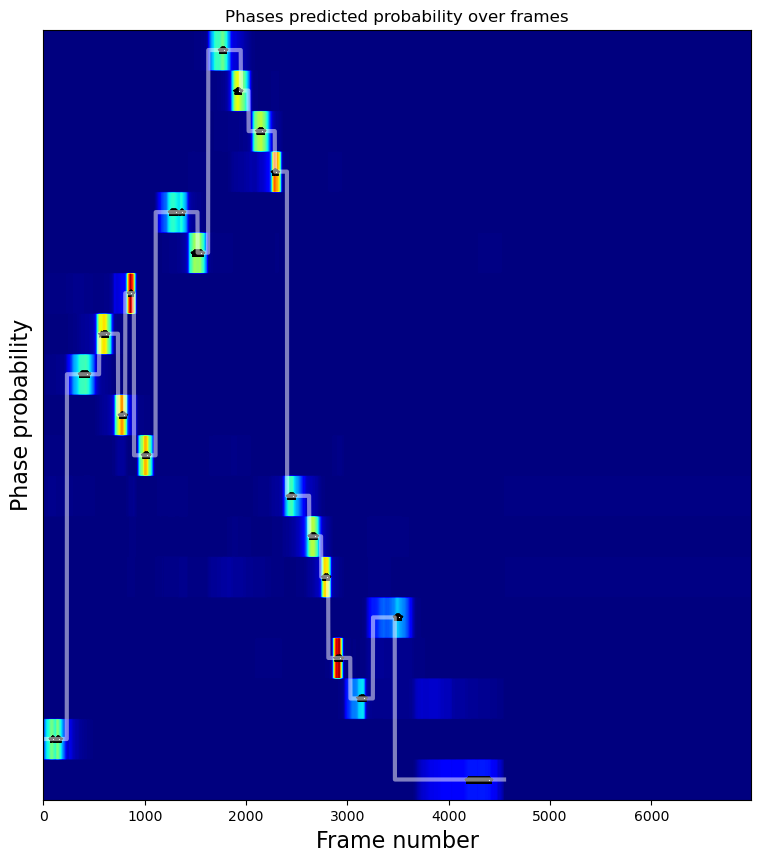

In [190]:
import scipy

n = 1
pred = predicted[n]
label = target[n]

lim = min(np.where(label == -100)[0])
label = label[:lim]
# pred = pred[:lim]

f = plt.figure(figsize=(10, 10))
softmax_preds = scipy.special.softmax(pred * 1, 1)
plt.imshow(np.repeat(softmax_preds, 400, 0), cmap='jet')
plt.plot((label * 400) + 200, linewidth=3, alpha=0.5, color='white')

# a simple mechanism for chosing the timestamps
thresh = 0.9
for i, phase_pred in enumerate(softmax_preds):
 timestamps = np.where(phase_pred > phase_pred.max() * 0.95)
 if len(timestamps):
   timestamps = timestamps[0]
  #  print(timestamps)
   plt.scatter(timestamps, [(i * 400) + 200] * len(timestamps), marker='*', s=20, color='white', edgecolors='black')

plt.grid(False)
plt.title('Phases predicted probability over frames')
plt.xlabel('Frame number', fontsize=16)
plt.ylabel('Phase probability', fontsize=16)
plt.yticks([])
plt.show()


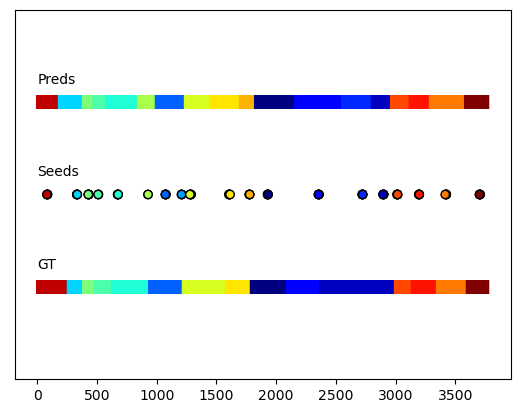

In [191]:
def plot_bars_with_seeds(labels, preds, phase2timestamps):
  n = len(preds)
  x = np.arange(n)
  ss = [100] * n

  xs = []
  ys = []
  for i, js in phase2timestamps.items():
    for j in js:
      xs.append(j)  
      ys.append(i)
 
  plt.scatter(xs, [1.1]*len(xs), c=ys, edgecolors="black", cmap='jet')
  plt.scatter(x, [1.2]*n, s=ss, marker="|", c=preds, cmap='jet')
  plt.scatter(x, [1]*n, s=ss, marker="|", c=labels, cmap='jet')

  plt.annotate("GT",(1, 1.02))
  plt.annotate("Seeds",(1, 1.12))
  plt.annotate("Preds",(1, 1.22))

  plt.ylim([0.9, 1.3])
  plt.yticks([])
  plt.show()

plot_bars_with_seeds(t, rw_preds, phase2timestamps)

In [167]:
##############################################################################
num_blocks = num_stages = 4
num_layers = 10
num_f_maps = 64
dim = features_dim = 2048
batch_size = bz = 8
lr = 0.0005
num_epochs = 50
dataset = '50salads'
split = '1'

sample_rate = 1
if dataset == "50salads":
    sample_rate = 2

vid_list_file = "/home/jupyter/data/"+dataset+"/splits/train.split"+split+".bundle"
vid_list_file_tst = "/home/jupyter/data/"+dataset+"/splits/test.split"+split+".bundle"
features_path = "/home/jupyter/data/"+dataset+"/features/"
gt_path = "/home/jupyter/data/"+dataset+"/groundTruth/"

mapping_file = "/home/jupyter/data/"+dataset+"/mapping.txt"

file_ptr = open(mapping_file, 'r')
actions = file_ptr.read().split('\n')[:-1]
file_ptr.close()
actions_dict = dict()
for a in actions:
    actions_dict[a.split()[1]] = int(a.split()[0])
num_classes = len(actions_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

use_rw = 'feature' # [feature, image, no]
do_eval = True
start_epochs = 30

##############################################################################

model = MultiStageModel(num_blocks, num_layers, num_f_maps, dim, num_classes)
ce = nn.CrossEntropyLoss(ignore_index=-100)
mse = nn.MSELoss(reduction='none')
model.train()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

batch_gen = BatchGenerator(num_classes, actions_dict, dataset, gt_path, features_path, sample_rate)
batch_gen.read_data(vid_list_file)

test_batch_gen = BatchGenerator(num_classes, actions_dict, dataset, gt_path, features_path, sample_rate)
test_batch_gen.read_data(vid_list_file_tst)

train_loss_list = []
train_timestamps_acc_list = []
train_pseudo_acc_list = []
train_labels_acc_list = []
train_pseudo_to_labels_acc_list = []

test_loss_list = []
test_timestamps_acc_list = []
test_pseudo_acc_list = []
test_labels_acc_list = []
test_pseudo_to_labels_acc_list = []

print('start epoch of single supervision is:', start_epochs)
for epoch in range(num_epochs):
    model.train()
    train_epoch_mets = run_epoch(batch_gen, model, epoch, use_rw, is_train=True)
    print("[epoch {}] Train || loss: {:.3f} | timestamps acc: {:.3f} | pseudo acc: {:.3f} | labels acc: {:.3f}".format(
        train_epoch_mets['epoch'],
        train_epoch_mets['loss'],
        train_epoch_mets['timestamps_acc'],
        train_epoch_mets['pseudo_acc'],
        train_epoch_mets['labels_acc']))

    train_loss_list.append(train_epoch_mets['loss'])
    train_timestamps_acc_list.append(train_epoch_mets['timestamps_acc'])
    train_pseudo_acc_list.append(train_epoch_mets['pseudo_acc'])
    train_labels_acc_list.append(train_epoch_mets['labels_acc'])
    train_pseudo_to_labels_acc_list.append(train_epoch_mets['pseudo_to_labels'])

    if do_eval:
        model.eval()
        test_epoch_mets = run_epoch(test_batch_gen, model, epoch, use_rw, is_train=False)
        print("[epoch {}] Test  || loss: {:.3f} | timestamps acc: {:.3f} | pseudo acc: {:.3f} | labels acc: {:.3f}".format(
            test_epoch_mets['epoch'],
            test_epoch_mets['loss'],
            test_epoch_mets['timestamps_acc'],
            test_epoch_mets['pseudo_acc'],
            test_epoch_mets['labels_acc']))

    test_loss_list.append(test_epoch_mets['loss'])
    test_timestamps_acc_list.append(test_epoch_mets['timestamps_acc'])
    test_pseudo_acc_list.append(test_epoch_mets['pseudo_acc'])
    test_labels_acc_list.append(test_epoch_mets['labels_acc'])
    test_pseudo_to_labels_acc_list.append(test_epoch_mets['pseudo_to_labels'])
    
print('Predict and eval')
train_mets = run_eval(model, batch_gen, actions_dict)
print('\nTRAIN')
print('\n'.join(['{}: {}'.format(k, np.round(v,3)) for k, v in train_mets.items()]))
test_mets = run_eval(model, test_batch_gen, actions_dict)
print('\nTEST')
print('\n'.join(['{}: {}'.format(k, np.round(v,3)) for k, v in test_mets.items()]))

start epoch of single supervision is: 30
[epoch 1] Train || loss: 3.109 | timestamps acc: 0.049 | pseudo acc: 0.000 | labels acc: 0.059
[epoch 1] Test  || loss: 4.661 | timestamps acc: 0.048 | pseudo acc: 0.000 | labels acc: 0.069
[epoch 2] Train || loss: 3.016 | timestamps acc: 0.054 | pseudo acc: 0.000 | labels acc: 0.058
[epoch 2] Test  || loss: 4.588 | timestamps acc: 0.048 | pseudo acc: 0.000 | labels acc: 0.069
[epoch 3] Train || loss: 2.938 | timestamps acc: 0.048 | pseudo acc: 0.000 | labels acc: 0.060
[epoch 3] Test  || loss: 4.530 | timestamps acc: 0.048 | pseudo acc: 0.000 | labels acc: 0.069
[epoch 4] Train || loss: 2.854 | timestamps acc: 0.062 | pseudo acc: 0.000 | labels acc: 0.064
[epoch 4] Test  || loss: 4.403 | timestamps acc: 0.048 | pseudo acc: 0.000 | labels acc: 0.069
[epoch 5] Train || loss: 2.781 | timestamps acc: 0.063 | pseudo acc: 0.000 | labels acc: 0.064
[epoch 5] Test  || loss: 4.295 | timestamps acc: 0.048 | pseudo acc: 0.000 | labels acc: 0.071
[epoch 6]

In [ ]:
plot(train_loss_list, test_loss_list, title='Loss')
plot(train_labels_acc_list, test_labels_acc_list, title='Labels Acc')
plot(train_pseudo_acc_list, test_pseudo_acc_list, title='Pseudo Acc')
plot(train_timestamps_acc_list, test_timestamps_acc_list, title='Timestamps Acc')
plot(train_pseudo_to_labels_acc_list, test_pseudo_to_labels_acc_list, title='Pseudo to Labels Acc')

In [15]:
# debug code
from random_walk import e2e_random_walk

epoch_loss = 0
pseudo_correct = 0
labels_correct = 0
timestamps_correct = 0
num_timestamps = 0
total = 0

batch_gen.reset()
while batch_gen.has_next():
    batch_input, batch_target, mask, batch_confidence = batch_gen.next_batch(batch_size)
    batch_input, batch_target, mask = batch_input.to(device), batch_target.to(device), mask.to(device)
    with torch.no_grad():
        pred, predictions = model(batch_input, mask)
    _, predicted = torch.max(predictions[-1].data, 1)

    break
    # batch_boundary = batch_gen.get_rw_preds(batch_size, middle_pred.detach())
    # batch = batch_gen.list_of_examples[batch_gen.index - batch_size:batch_gen.index]
    # num_video, _, max_frames = pred.size()
    # boundary_target_tensor = torch.ones(num_video, max_frames, dtype=torch.long) * (-100)
    # for b, vid in enumerate(batch):
    #     timestamps = batch_gen.random_index[vid]
    #     labels = batch_gen.gt[vid].astype(int)
    #     features = pred[b].T[:len(labels),:]
    #     rw_pred_labels = e2e_random_walk(features, labels, timestamps, batch_gen.actions_dict)
    #     # rw_pred_labels = self.rw_preds[vid]
    #     boundary_target_tensor[b, :len(rw_pred_labels)] = torch.tensor(rw_pred_labels, dtype=torch.long)


In [ ]:
# Validate the FB and RW weak labels results
# test the accuracy of FB vs. RW

In [3]:
import matplotlib.pyplot as plt 

def vis(labels, rw_preds, rw_acc, fb_preds, fb_acc):
  n = len(labels)
  x = np.arange(n)
  ss = [100] * n

  plt.scatter(x, [1]*n, s=ss, marker="|", c=labels, cmap='jet')
  plt.scatter(x, [1.1]*n, s=ss, marker="|", c=rw_preds, cmap='jet')
  plt.scatter(x, [1.2]*n, s=ss, marker="|", c=fb_preds, cmap='jet')

  plt.annotate("GT",(1, 1.02))
  plt.annotate("RW preds Acc:{:.3f}".format(rw_acc),(1, 1.12))
  plt.annotate("FB preds Acc:{:.3f}".format(fb_acc),(1, 1.22))

  plt.ylim([0.9, 1.3])
  plt.yticks([])
  plt.show()


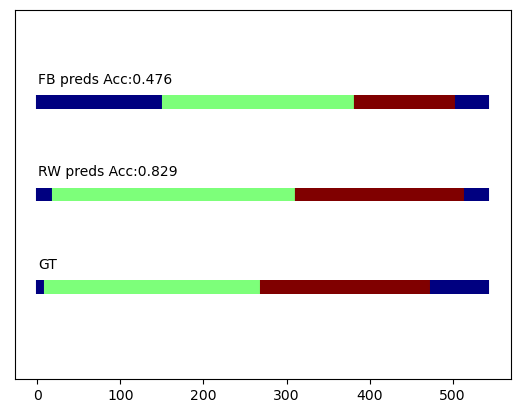

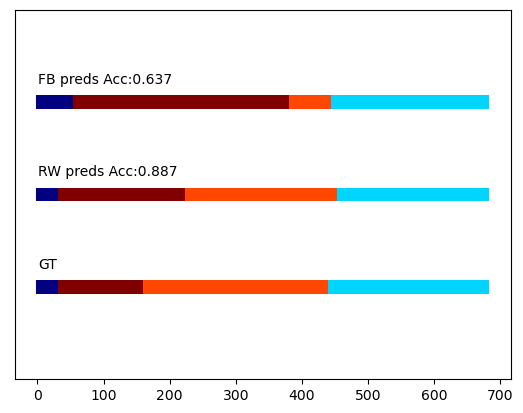

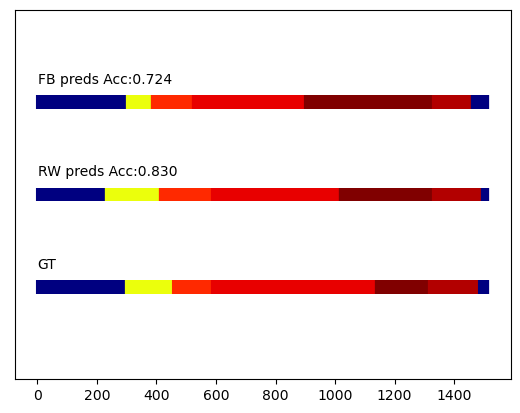

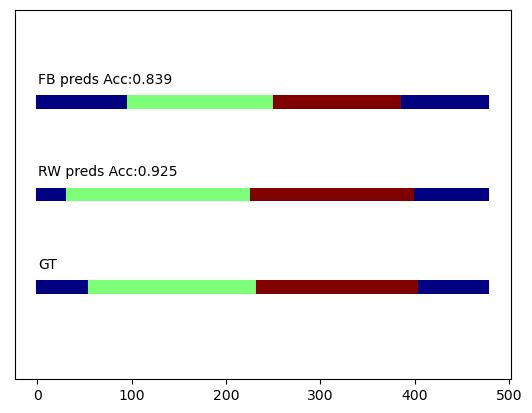

RW: 0.7612 | FB: 0.6457
FB
F1@0.10: 89.8250
F1@0.25: 75.1373
F1@0.50: 48.0182
Edit: 100.0000
Acc: 60.5137
None
RW
F1@0.10: 98.3616
F1@0.25: 90.2042
F1@0.50: 70.8869
Edit: 99.7562
Acc: 73.2601
None


In [13]:
import pickle 

dataset = 'breakfast'
plot_every = 500

vid_list_file = "./data/"+dataset+"/splits/train.split"+split+".bundle"
vid_list_file_tst = "./data/"+dataset+"/splits/test.split"+split+".bundle"
gt_path = "./data/"+dataset+"/groundTruth/"
mapping_file = "./data/"+dataset+"/mapping.txt"

file_ptr = open(mapping_file, 'r')
actions = file_ptr.read().split('\n')[:-1]
file_ptr.close()
actions_dict = dict()
for a in actions:
    actions_dict[a.split()[1]] = int(a.split()[0])
actions_dict_rev = {v:k for k, v in actions_dict.items()}

file_ptr = open(vid_list_file, 'r')
list_of_examples_train = file_ptr.read().split('\n')[:-1]
file_ptr.close()
file_ptr = open(vid_list_file_tst, 'r')
list_of_examples_test = file_ptr.read().split('\n')[:-1]
file_ptr.close()
list_of_examples = list_of_examples_train + list_of_examples_test

naive_file_name = "./data/"+dataset+"/naive_preds.pickle"
with open(naive_file_name, 'rb') as f:
    vid_name2naive_preds = pickle.load(f)
rw_file_name = "./data/"+dataset+"/rw_preds.pickle"
with open(rw_file_name, 'rb') as f:
    vid_name2rw_preds = pickle.load(f)

rw_met = MetricLoger()
fb_met = MetricLoger()
rw_acc = []
fb_acc = []
for i, vid_name in enumerate(list_of_examples):
    file_ptr = open(gt_path + vid_name, 'r')
    labels = np.array(file_ptr.read().split('\n')[:-1])
    if dataset == '50salads':
        labels = labels[::2]

    rw_preds = vid_name2rw_preds[vid_name]
    fb_preds = vid_name2naive_preds[vid_name]
    
    rw_preds = np.array([actions_dict_rev[i] for i in rw_preds])
    fb_preds = np.array([actions_dict_rev[i] for i in fb_preds])
    
    rw_met.update(labels, rw_preds)
    fb_met.update(labels, fb_preds)
    
    rw_acc_ = np.mean(labels == rw_preds)
    fb_acc_ = np.mean(labels == fb_preds)
    if i % plot_every == 0:
        vis([actions_dict[l] for l in labels],
            [actions_dict[l] for l in rw_preds],
            rw_acc_, [actions_dict[l] for l in fb_preds],
            fb_acc_)
    rw_acc.append(rw_acc_)
    fb_acc.append(fb_acc_)

print('RW: {:.4f} | FB: {:.4f}'.format(np.mean(rw_acc), np.mean(fb_acc)))
print('FB')
print(fb_met.calc())
print('RW')
print(rw_met.calc())